In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

 # PSF Sub and Halo Finding

The code in this notebook is to test and showcase written functions for the python environment 'pycube'. It is designed to analyze MUSE data containers and the surrounding halo around QSOs and neighboring supermassive black holes. 

## Imports and data reading

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sep
from photutils import EllipticalAperture
import scipy as sp
from PIL import Image

import pycube
from pycube.core import background
from pycube.core import manip
from pycube import msgs
from pycube import core
from pycube import cubeClass
from pycube import psf
from pycube import halos
from pycube.instruments import vlt_muse
from IPython import embed
import math
import gc

There are three datasets that have been used for testing this program.

Random MUSE data (no LYa halo, but halo detection) <- Seyfert 1 galaxy

In [2]:
DATA_DIR = ('/home/ryan.foley/Downloads/ADP_MUSECOPY.fits')

--------------------

Initializes the class object 'test_cube' and initializes the data table by calling 'from_fits_file'. In the future this function will have multiple specifications for the second parameter for different instruments.


In [3]:
test_cube = cubeClass.IfuCube(DATA_DIR, vlt_muse)

Next we can initialize our test_cube object so that the various module's functions will operate on it.

In [4]:
test_cube.initialize_file()


This program is written with the assumption those using it know the RA and DEC of their object of interest. To recieve the coordinates in pixel value call the function object_coord from the manip module with your cube object, RA, & DEC as arguments.

In [5]:
# for ADPrandom
x_pos, y_pos = manip.object_coord(test_cube, 226.03207, -2.804395)

# Data Manipulation

The code is designed for users to specify how much of the container they want to analyze and on which axis they want to collapse upon. Given these are large data sets, analysis of a smaller section can be beneficial for hardware restraints. 

## Viewing Data

We can view the fits table which gives us the header descriptions of values and constants in the data as well as dimensions for our data container. We have a data set and 'stat' set, which is an equally sized variance cube of our data. 

In [7]:
del test_cube.hdul[3:] # deleted rows, as this was test data for write-to functions 
test_cube.hdul.info()

Filename: /home/ryan.foley/Downloads/ADPrandomCOPY.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1355   ()      
  1  DATA          1 ImageHDU        44   (329, 316, 3681)   float32   
  2  STAT          1 ImageHDU        44   (329, 316, 3681)   float32   


The header file for the data row provides details about the various parameters stored within the data. 

In [8]:
test_cube.hdul[1].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  329 / length of data axis 1                          
NAXIS2  =                  316 / length of data axis 2                          
NAXIS3  =                 3681 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
OBJECT  = 'RXCJ1504.1-0248 (DATA)'                                              
CRPIX1  =     170.357588818887 / Pixel coordinate of reference point            
CRPIX2  =     156.543710915564 / Pixel coordinate of reference point            
CD1_1   = -5.55555555555556E-05 / Coordinate transformation matrix element      
CD1_2   =                   

## Cube Collapsing 

Here we can collapse along a range of wavelength values, which is our z-axis, to produce a flattened section of the cube. We test shape and also produce an image of the collapsed section.

In [9]:
collapsed_300D, collapsed_300S = manip.collapse_container(test_cube,
                                                          0, 300)


In [10]:
np.shape(collapsed_300D)

(316, 329)

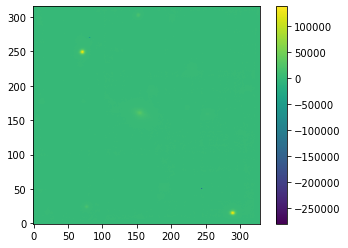

In [11]:
plt.imshow(collapsed_300D, origin = 'lower')
plt.colorbar()

In [12]:
plt.close()

Alternatively, we could not specify a range and the function will collapse the entire container.

In [13]:
collapsed_fullD, collapsed_fullS = manip.collapse_container(test_cube)


collapse_cube : Exceeded / unspecified wavelength in data cube. Max value is set to 3681
collapse_cube : Invalid / unspecified minimum wavelength. Min value is set to 0


In [14]:
np.shape(collapsed_fullD)

(316, 329)

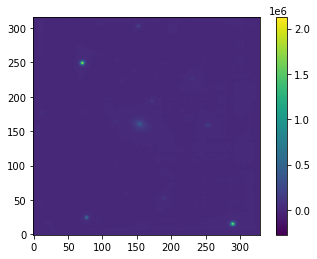

In [15]:
plt.imshow(collapsed_fullD, origin = 'lower')
plt.colorbar()

In [16]:
plt.close()

In [17]:
gc.collect()

25

## De-reddening

There is an added function to correct for de-reddening of the data from cosmic dust. This function converts the entire data container which can then be re-collapsed and analyzed.

In [18]:
deRed_fullD, deRed_fullS = manip.dust_correction(test_cube)

In [19]:
deRed_collapse = manip.collapse_cube(deRed_fullD)

collapse_cube : Exceeded / unspecified wavelength in data cube. Max value is set to 3681
collapse_cube : Invalid / unspecified minimum wavelength. Min value is set to 0


In [20]:
np.shape(deRed_collapse)

(316, 329)

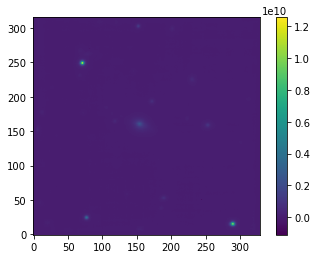

In [21]:
plt.imshow(deRed_collapse, origin = 'lower')
plt.colorbar()

In [22]:
plt.close()

In [23]:
gc.collect()
gc.collect()

0

# Background and Sources

## Background Sub

First we want to remove any residual sources in the background.

subtractBg is a function which utilizes SEP to smooth the background after isolating the sources. SEP is a re-creation of SourceXtractor for Python.

subtractBg: Starting the procedure to subtract the background
statBg: Starting estimate of b/g stats
collapse_cube : Exceeded / unspecified wavelength in data cube. Max value is set to 3681
collapse_cube : Invalid / unspecified minimum wavelength. Min value is set to 0
statBg: Searching for sources in the collapsed cube
collapse_cube : Exceeded / unspecified wavelength in data cube. Max value is set to 3681
collapse_cube : Invalid / unspecified minimum wavelength. Min value is set to 0
statBg: Detected 25 sources
statBg: Masking sources
statBg: Masking Edges
statBg: Performing b/g statistic
statBg: Saving debug image on /home/ryan.foley/Downloads/ADPrandomCOPY.fits_BgRegion.pdf


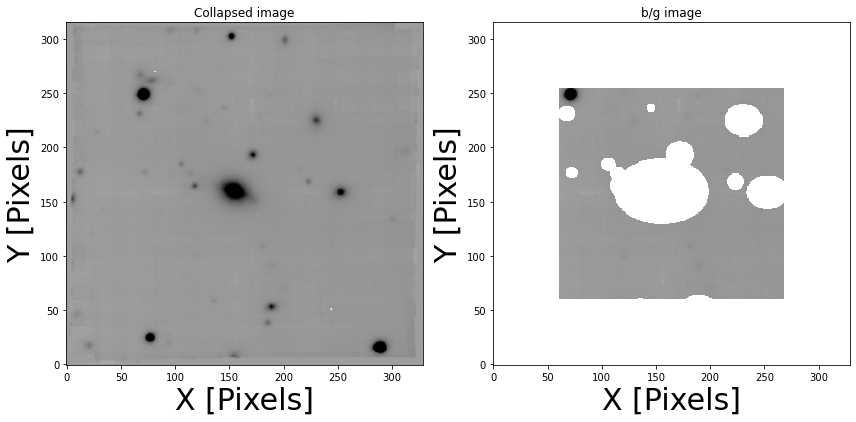

subtractBg: Subtracting background from datacube
subtractBg: Estimating correction for statcube variance


subtractBg: The average correction factor for variance is 5.91499
nicePlot: Setting rcParams


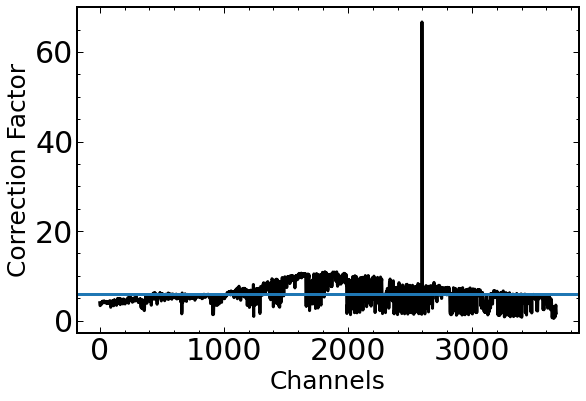

subtractBg: The average value subtracted to the b/g level is 0.98333
nicePlot: Setting rcParams


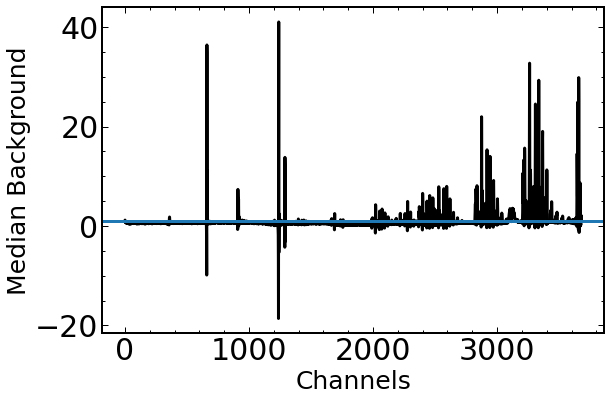

0

In [7]:
dataBg, statBg,_,_,_,_,_,_,_  = psf.subtractBg(test_cube,
                                               sig_source_detect = 0.05,
                                               min_source_area=2.,
                                               source_mask_size=5.,
                                               edges=60,
                                               output = DATA_DIR,
                                               debug = True,
                                               showDebug = True)
gc.collect()
gc.collect()

statBg: Starting estimate of b/g stats
collapse_cube : Exceeded / unspecified wavelength in data cube. Max value is set to 3681
collapse_cube : Invalid / unspecified minimum wavelength. Min value is set to 0
statBg: Searching for sources in the collapsed cube
collapse_cube : Exceeded / unspecified wavelength in data cube. Max value is set to 3681
collapse_cube : Invalid / unspecified minimum wavelength. Min value is set to 0
statBg: Detected 25 sources
statBg: Masking sources
statBg: Masking Edges
statBg: Performing b/g statistic
statBg: Saving debug image on /home/ryan.foley/Downloads/ADPrandomCOPY.fits_BgRegion.pdf


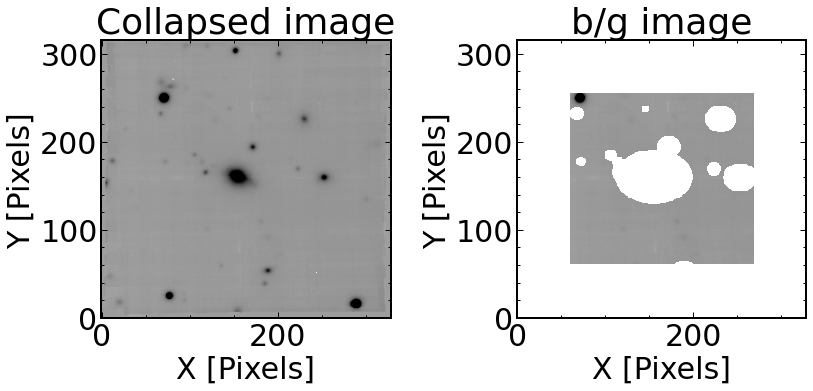

0

In [25]:
averageBg, medianBg, stdBg, varBg, pixelsBg, maskBg2D, bgDataImage = psf.statBg(test_cube,
                                                                                sig_source_detect=0.05,
                                                                                min_source_area=2.,
                                                                                source_mask_size=5.,
                                                                                edges=60,
                                                                                output = DATA_DIR,
                                                                                debug = True,
                                                                                showDebug = True)
gc.collect()
gc.collect()

## Writing to File

Here we have a function which performs the above tasks of background isolation and source masking. It iterates through the entire cube, and writes the background and masks to the .Fits.

Below it shows the now updated .fits with added rows for 'MASK' and 'BACKGROUND'.

We can showcase an example of the new sections by slicing a single wavelength and plotting the image. 

# Wavelengths

## Atmosphere 

We can also convert our channel values into wave lengths using the 'convert_to_wave' function from the manip module.

In [26]:
wavearray = manip.convert_to_wave(test_cube,test_cube.get_data())

Ploting the subtracted background average, median and sigma with the wave lengths yields the plot below. Notice that sigma is our atmospheric background.

Text(0.5, 1.0, '/home/ryan.foley/Downloads/ADPrandomCOPY.fits')

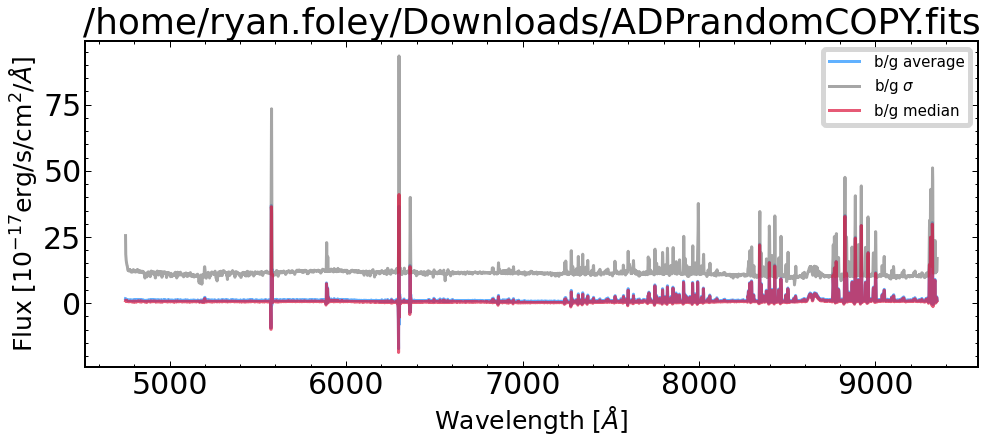

In [27]:
plt.figure(0, figsize=(16,6))
plt.plot(wavearray, averageBg, alpha=0.7, color='dodgerblue', label='b/g average')
plt.plot(wavearray, stdBg, alpha=0.7, color='grey', label='b/g $\sigma$')
plt.plot(wavearray, medianBg, alpha=0.7, color='crimson', label='b/g median')
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [10$^{-17}$erg/s/cm$^2$/$\AA$]')
plt.legend(prop={"size": 15})
plt.title(DATA_DIR)


In [28]:
plt.close()

## Quasar Spectrum

Using the function 'quickSpectrum' from the manip module, we can extract the spectra from the object of interest.

In [29]:
fluxQso, errQso, bgQso = manip.quickSpectrum(test_cube,x_pos,y_pos)

We can plot the the data wavelengths against this flux 

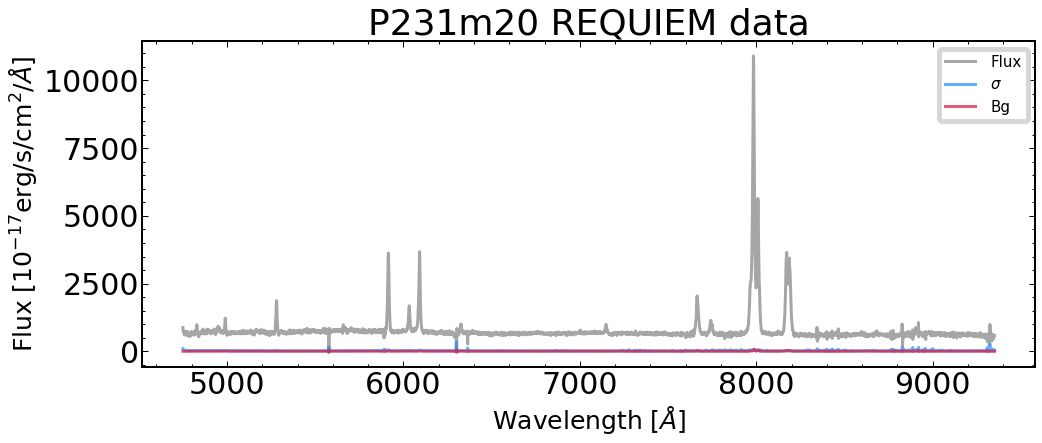

In [30]:
plt.figure(0, figsize=(16,6))
plt.plot(wavearray,fluxQso, alpha = 0.7, color = 'grey', label = "Flux")
plt.plot(wavearray,errQso,alpha = 0.7, color = 'dodgerblue', label = "$\sigma$")
plt.plot(wavearray,bgQso,alpha = 0.7, color = 'crimson', label = "Bg")
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel(r'Flux [10$^{-17}$erg/s/cm$^2$/$\AA$]')
plt.title('P231m20 REQUIEM data')
plt.legend(prop={'size': 15})

In [31]:
plt.close()

------------------

Another helpful function is to call .get_dimensions on the IFUcube object to quickly get its value ranges. Specifically, this is helpful to see the channel ranges of the previous plot.

In [32]:
z_max, y_max, x_max = test_cube.get_dimensions()
channelarray = np.arange(0,z_max, 1)

1601

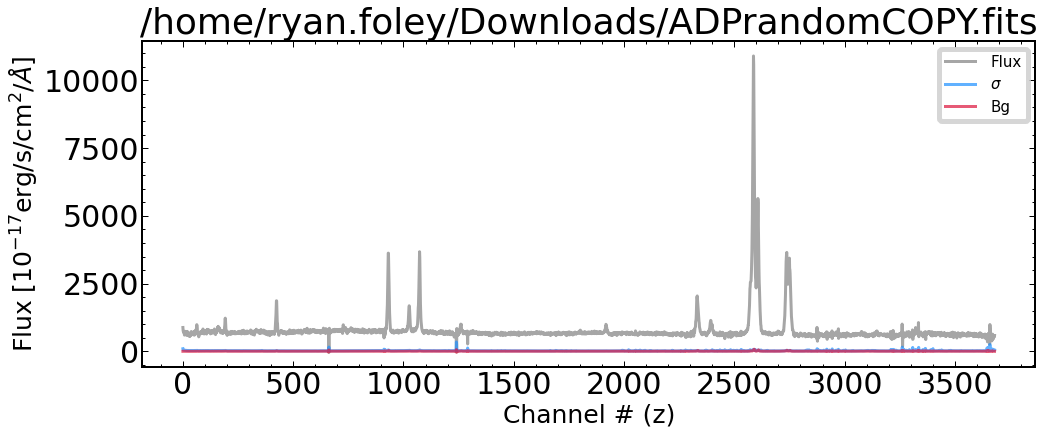

In [33]:
plt.figure(0, figsize=(16,6))
plt.plot(channelarray,fluxQso, alpha = 0.7, color = 'grey', label = "Flux")
plt.plot(channelarray,errQso,alpha = 0.7, color = 'dodgerblue', label = "$\sigma$")
plt.plot(channelarray,bgQso,alpha = 0.7, color = 'crimson', label = "Bg")
plt.xlabel(r'Channel # (z)')
plt.ylabel(r'Flux [10$^{-17}$erg/s/cm$^2$/$\AA$]')
plt.title(DATA_DIR)
plt.legend(prop={'size': 15})

gc.collect()

 From this plot, we can easily visualize the channel values where we need to cut off / shrink the cube to perform the following functions in the package.

 ----------------

# Point Spread Function

The following code impliments a point-spread function to remove the highly luminous QSO to isolate the potential surround halo.

## PSF Creation

The first step is to normalize the flux produced by the QSO. using cType=sum does just this. We also need to perform this function along the continuum just beyond were we estimate our LYa emission to be.

makePsf: Creating PSF model
makePsf: Summing channels
quickApPhotmetry: Performing aperture photometry
Source 1 : Aperture photometry on source at: 156.8755888186492, 160.77371091556373
makePsf: Removing local background of [21.33357716]
makePsf: Normalizing central region to 1
         (i.e. correcting for a factor [214946.80125839]
makePsf: Creating circular mask around the position 156.8755888186492, 160.77371091556373
location: single source identified
makePsf: Creating debug images
nicePlot: Setting rcParams


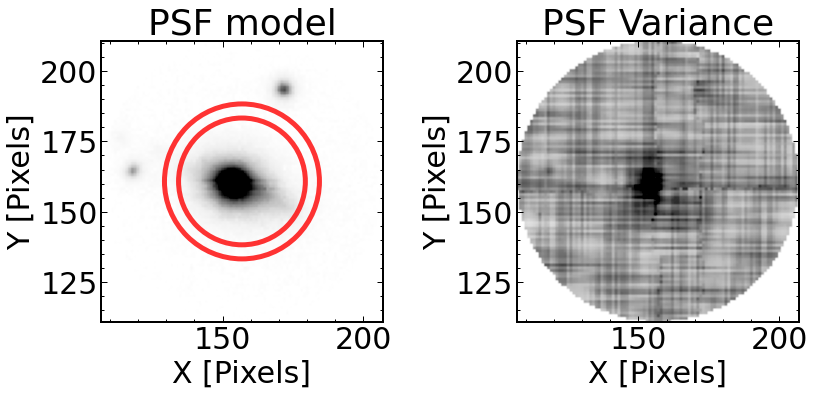

0

In [34]:
psf_data, psf_stat = psf.makePsf(dataBg,statcube=statBg,x_pos=x_pos,y_pos=y_pos,
                                 inner_rad=45,outer_rad=55,
                                 min_lambda=2660,max_lambda=2850,
                                 debug = True,showDebug=True, cType = 'sum')
gc.collect()
gc.collect()

-------------

## PSF Cleaning

The function 'clean_psf' from the fitting psf module takes the now normalized psf model and subtracts the contribution.

cleanPsf: PSF subtraction on cube
cleanPsf: The min, max values for PSF model are: -0.0033, 0.1446
cleanPsf: Spectrum of the source
nicePlot: Setting rcParams


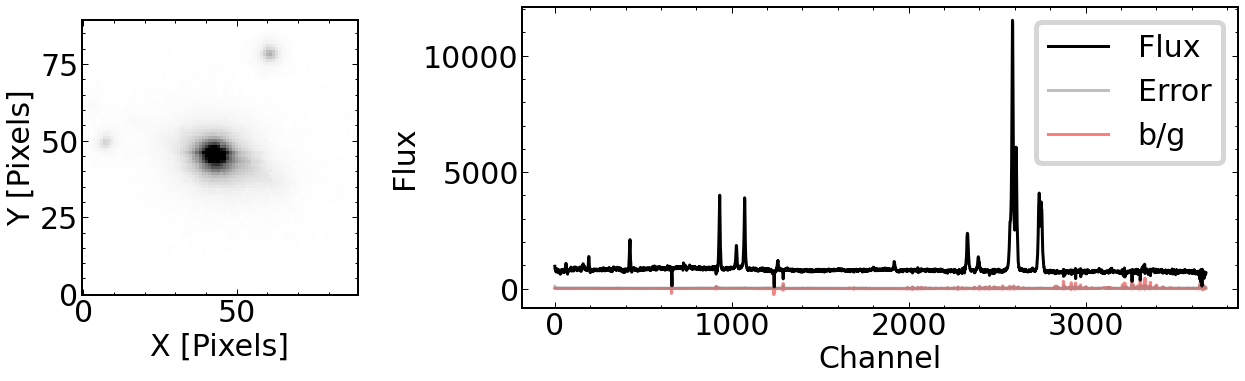

cleanPsf: PSF cleaning performed


0

In [35]:
dataCubeClean, dataCubeModel = psf.clean_psf(test_cube,
                                            psf_model=psf_data,
                                            x_pos=x_pos,y_pos=y_pos,
                                            debug=True,radius_pos=2.,
                                            inner_rad=45.,outer_rad=55.,
                                            show_debug = True) 
gc.collect()
gc.collect()

# Halo Finding

To preserve memory and remain accurate, we use two parameters here to smooth our data. These are the background corrected data and variance cubes. The function 'smoothChiCube' smooths the cube in the spatial (a_smooth) and spectral (v_smooth) axes.

We use the above plots to set our shrinking parameters min and max lambda.

In [36]:
chiCube, sChiCube = halos.smoothChiCube(dataCubeClean,statcube=statBg,
                                        min_lambda=2550,
                                        max_lambda=2650,
                                        a_smooth=1,
                                        v_smooth=2)
np.shape(sChiCube)

smoothChiCube: Shrinking Cube with given parameters
smoothChiCube: Smoothing Cube with 3D Gaussian Kernel


(100, 316, 329)

----------------

maskHalo is the crutial function to the halo finding module. This function performs a friend of friend function on the now smoothed and background corrected cube. 

mask_halo: removing inner region around (x,y)=(156.88,160.77)
          with radius 2 pixels
location: single source identified
mask_halo: removing outer region around (x,y)=(156.88,160.77)
          with radius 40 pixels
location: single source identified
mask_halo: defining threshold level
statFullCube: statistic on the cube
statFullCube: average = -0.127
              median  = -0.035
              sigma   = +0.531
statFullCubeZ: statistic on the cube
mask_halo: the median value of the voxels is: -0.0348
          and the sigma is: +0.5308
mask_halo: the average relative threshold value set to 1.60*0.5308=0.8492
mask_halo: Saving debug image on Object_voxelDistribution.pdf
          in principle the distribution should be gaussian
          showing only channel 50
nicePlot: Setting rcParams


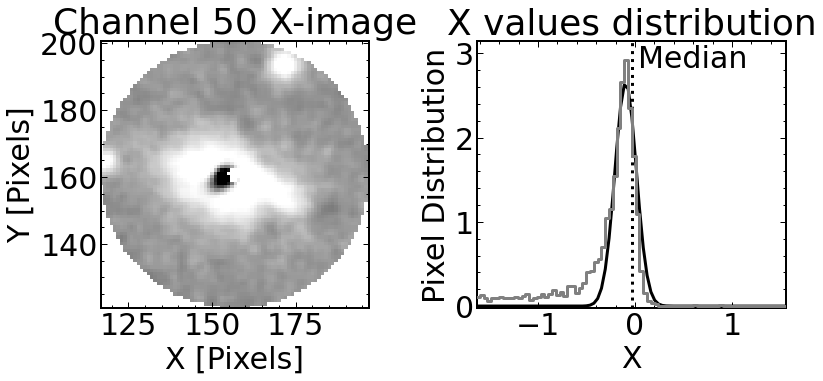

mask_halo: searching for extended emission
          starting from from (x,y,z)=(156.88,160.774,50)
mask_halo: the maximum S/N detected is 8.360 
          at the location (x,y,z)=(151,161,44)
mask_halo: starting to fill the halo mask
mask_halo: Creating debug image
          Plotting Channel 44 where the most significant voxel is.
          The location of this voxel is marked with a red circle
          The position of the quasars is in blue
nicePlot: Setting rcParams
spectralMaskHalo: collapsing halo mask
mask_halo: debug image saved in Object_maskHaloStartingVoxel.pdf


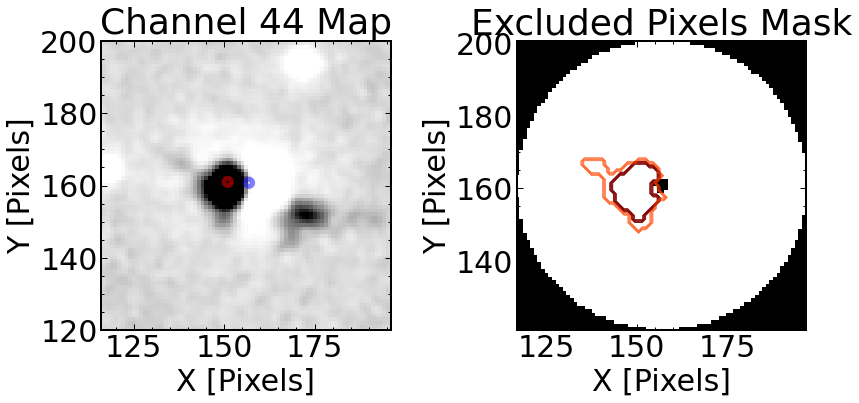

21347

In [37]:
maskHalo = halos.maskHalo(sChiCube,
                          x_pos=x_pos,
                          y_pos=y_pos,
                          z_pos=50,
                          rad_bad_pix=2,
                          rad_max=40,
                          r_connect=2,
                          threshold=1.6,
                          threshold_type='relative',
                          bad_pixel_mask=None,
                          output='Object',
                          debug=True,
                          showDebug=True)
gc.collect()